In [1]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/IMDB Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re
import pandas as pd
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem.porter import PorterStemmer

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#**Text Preprocessing**

In [4]:
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)            # strip HTML
    text = re.sub(r'[^a-zA-Z ]', '', text)       # keep letters & spaces
    tokens = text.lower().split()
    return [stemmer.stem(tok) for tok in tokens]

In [5]:
print("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)
df['tokens'] = df['review'].apply(preprocess_text)
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)

Loading and preprocessing data...


#**Train/Val/Test split**

In [6]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
df_val, df_test   = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

#**Building vocabulary**

In [7]:
MIN_FREQ = 2
MAX_VOCAB_SIZE = 5000
counter = Counter(tok for tokens in df_train['tokens'] for tok in tokens)
common = [tok for tok, cnt in counter.items() if cnt >= MIN_FREQ]
common = sorted(common, key=lambda x: counter[x], reverse=True)[:MAX_VOCAB_SIZE]
itos = ['<PAD>', '<UNK>'] + common
stoi = {tok: idx for idx, tok in enumerate(itos)}
VOCAB_SIZE = len(itos)
print(f"Vocab size: {VOCAB_SIZE}")

Vocab size: 5002


In [8]:
def encode(tokens):
    return [stoi.get(tok, stoi['<UNK>']) for tok in tokens]

class IMDBDataset(Dataset):
    def __init__(self, df):
        self.texts = [torch.tensor(encode(toks), dtype=torch.long) for toks in df['tokens']]
        self.labels = torch.tensor(df['label'].values, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([t.size(0) for t in texts])
    padded = pad_sequence(texts, batch_first=True, padding_value=stoi['<PAD>'])
    return padded, lengths, torch.stack(labels)

In [9]:
batch_size = 64
num_workers = 4
pin_memory = True if device.type=='cuda' else False

train_ds = IMDBDataset(df_train)
val_ds   = IMDBDataset(df_val)
test_ds  = IMDBDataset(df_test)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#**RNN Model (LSTM/GRU)**

In [10]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 n_layers=1, rnn_type='LSTM', dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi['<PAD>'])
        if rnn_type=='LSTM':
            self.rnn = nn.LSTM(
                embed_dim, hidden_dim,
                num_layers=n_layers,
                batch_first=True,
                dropout=dropout if n_layers>1 else 0
            )
        else:
            self.rnn = nn.GRU(
                embed_dim, hidden_dim,
                num_layers=n_layers,
                batch_first=True,
                dropout=dropout if n_layers>1 else 0
            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        packed_out, hidden = self.rnn(packed)
        if isinstance(hidden, tuple):
            hidden = hidden[0]
        out = self.dropout(hidden[-1])
        return self.fc(out)

In [11]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for texts, lengths, labels in loader:
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(texts, lengths)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, lengths, labels in loader:
            texts, lengths = texts.to(device), lengths.to(device)
            logits = model(texts, lengths)
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())
    report = classification_report(all_labels, all_preds, target_names=['neg','pos'])
    cm = confusion_matrix(all_labels, all_preds)
    return total_loss/len(loader), report, cm

In [12]:
# Best Hyperparameters
embed_dims = [50, 100]
hidden_dims = [128, 256]
dropouts = [0.3, 0.5]
rnn_types = ['LSTM', 'GRU']
best_loss, best_params = float('inf'), None

for rnn_type in rnn_types:
    for e in embed_dims:
        for h in hidden_dims:
            for d in dropouts:
                print(f"Testing {rnn_type}, emb={e}, hid={h}, drop={d}")
                model = RNNClassifier(VOCAB_SIZE, e, h, 2, n_layers=1,
                                      rnn_type=rnn_type, dropout=d).to(device)
                opt = optim.Adam(model.parameters(), lr=1e-3)
                crit = nn.CrossEntropyLoss()
                for _ in range(2):
                    train_epoch(model, train_loader, opt, crit)
                loss, report, _ = eval_model(model, val_loader, crit)
                print(report)
                if loss < best_loss:
                    best_loss, best_params = loss, (rnn_type, e, h, d)
print("Best params:", best_params)

Testing LSTM, emb=50, hid=128, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.89      0.70      0.78      2500
         pos       0.75      0.91      0.82      2500

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.80      5000
weighted avg       0.82      0.81      0.80      5000

Testing LSTM, emb=50, hid=128, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.77      0.87      0.82      2500
         pos       0.86      0.75      0.80      2500

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000

Testing LSTM, emb=50, hid=256, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.80      0.84      0.82      2500
         pos       0.83      0.79      0.81      2500

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

Testing LSTM, emb=50, hid=256, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.78      0.84      0.81      2500
         pos       0.83      0.77      0.80      2500

    accuracy                           0.80      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000

Testing LSTM, emb=100, hid=128, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.85      0.88      0.86      2500
         pos       0.87      0.84      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Testing LSTM, emb=100, hid=128, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.85      0.82      0.83      2500
         pos       0.82      0.86      0.84      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

Testing LSTM, emb=100, hid=256, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.76      0.93      0.84      2500
         pos       0.91      0.71      0.80      2500

    accuracy                           0.82      5000
   macro avg       0.84      0.82      0.82      5000
weighted avg       0.84      0.82      0.82      5000

Testing LSTM, emb=100, hid=256, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.90      0.82      0.86      2500
         pos       0.84      0.91      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Testing GRU, emb=50, hid=128, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.92      0.82      0.87      2500
         pos       0.84      0.93      0.88      2500

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000

Testing GRU, emb=50, hid=128, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.89      0.86      0.87      2500
         pos       0.86      0.89      0.88      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Testing GRU, emb=50, hid=256, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.89      0.84      0.87      2500
         pos       0.85      0.90      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Testing GRU, emb=50, hid=256, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.84      0.90      0.87      2500
         pos       0.89      0.83      0.86      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Testing GRU, emb=100, hid=128, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.89      0.87      0.88      2500
         pos       0.87      0.89      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Testing GRU, emb=100, hid=128, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.91      0.75      0.82      2500
         pos       0.79      0.93      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.85      0.84      0.84      5000

Testing GRU, emb=100, hid=256, drop=0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.91      0.86      0.88      2500
         pos       0.87      0.91      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Testing GRU, emb=100, hid=256, drop=0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.82      0.91      0.86      2500
         pos       0.90      0.80      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000

Best params: ('GRU', 100, 256, 0.3)


In [13]:
rnn_type, e, h, d = best_params
model = RNNClassifier(VOCAB_SIZE, e, h, 2, n_layers=1,
                      rnn_type=rnn_type, dropout=d).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(5):
    tr_loss = train_epoch(model, train_loader, opt, crit)
    val_loss, val_rep, _ = eval_model(model, val_loader, crit)
    print(f"Epoch {epoch+1}: Train {tr_loss:.3f}, Val {val_loss:.3f}\n" + val_rep)

test_loss, test_rep, test_cm = eval_model(model, test_loader, crit)
print("Test report:\n", test_rep)
print("Confusion Matrix:\n", test_cm)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train 0.562, Val 0.359
              precision    recall  f1-score   support

         neg       0.85      0.84      0.84      2500
         pos       0.84      0.85      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Train 0.300, Val 0.279
              precision    recall  f1-score   support

         neg       0.85      0.92      0.88      2500
         pos       0.91      0.84      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Train 0.232, Val 0.249
              precision    recall  f1-score   support

         neg       0.89      0.90      0.90      2500
         pos       0.90      0.89      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Train 0.186, Val 0.251
              precision    recall  f1-score   support

         neg       0.90      0.90      0.90      2500
         pos       0.90      0.90      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Train 0.138, Val 0.267
              precision    recall  f1-score   support

         neg       0.91      0.88      0.89      2500
         pos       0.89      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test report:
               precision    recall  f1-score   support

         neg       0.90      0.90      0.90      2500
         pos       0.90      0.90      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Confusion Matrix:
 [[2239  261]
 [ 243 2257]]


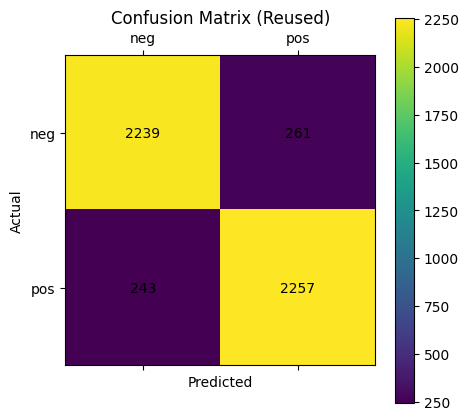

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.matshow(test_cm)
fig.colorbar(cax)
for (i, j), val in np.ndenumerate(test_cm):
    ax.text(j, i, val, ha='center', va='center')
ax.set_xticks([0,1]); ax.set_xticklabels(['neg','pos'])
ax.set_yticks([0,1]); ax.set_yticklabels(['neg','pos'])
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Reused)')
plt.show()